# fMRI_Delay
## Notebook for experimentation on Results Validation

In [1]:
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy import stats, sparse
from itertools import combinations, permutations

import pickle
import os

import pandas as pd

import fmri_delay

# Loading es-fMRI Fullrun Data

In [2]:
def load_parcellation(path_to_pdm):
    path_to_pinfo = 'esfmri_connectivity/esfmri_connectivity/parcellation/'
    file = 'tpl-MNI152NLin2009cAsym_res-01_atlas-smorgasbord_dseg.tsv'
    
    parcels_info = pd.read_csv(path_to_pdm+path_to_pinfo+file, sep='\t').drop(columns = ['color', 'xyz'])\
                        .rename(columns = {'Unnamed: 0':'parcel_id'})#.set_index('parcel_id')
                        
    
    return parcels_info

ptpdm = '/Users/AlexCionca/Documents/PDM/_Data/'
p_infos = load_parcellation(ptpdm)

p_infos.head(2)

,parcel_id,abbr,name
0,1,NaN,7Networks_LH_Vis_1
1,2,NaN,7Networks_LH_Vis_2


In [3]:
#esfmri_exp = {'esfmri_processed':esfmri_processed, 'esfmri_real':esfmri_real,
#                          'esfmri_rand':esfmri_rand, 'parcel_data':parcel_data,
#                          'pre_thresh':pre_thresh, 'jitter':jitter}

with open('../pickle_data/CH_esfmri_fullrun_allsubj.pickle', 'rb') as f:
    esfmri_fullrun = pickle.load(f)
    
esfmri_processed = esfmri_fullrun['esfmri_processed']
esfmri_real = esfmri_fullrun['esfmri_real']
esfmri_rand = esfmri_fullrun['esfmri_rand']
parcel_data = esfmri_fullrun['parcel_data']
jitter = esfmri_fullrun['jitter']
pre_thresh = esfmri_fullrun['pre_thresh']

del esfmri_fullrun

done = [not (type(elem) == int) for elem in esfmri_real]

n_subjrun = sum(done)

isig_proc = [0]*n_subjrun
real_dc = [0]*n_subjrun
rand_nojit = [0]*n_subjrun
rand_jit = [0]*n_subjrun

for i, isdone in enumerate(done):
    if isdone:
        isig_proc[i] = esfmri_processed[i]
        real_dc[i] = esfmri_real[i][0]
        rand_nojit[i] = esfmri_rand[i][0, 0]
        rand_jit[i] = esfmri_rand[i][1, 0]

parcels = parcel_data.loc[done]

del esfmri_processed
del esfmri_real
del esfmri_rand

parcels.head(2)

,subject,run,overlapping_parcel_index,subj_run
0,292,1,198.0,sub-292-es_run-01
1,292,4,34.0,sub-292-es_run-04


In [4]:
def load_subj_parcels(path_to_pdm, parcels):
    path_to_pinfo = 'esfmri_connectivity/esfmri_connectivity/timeseries/'
    #file_suffix = 'sub-{}_ses-postop_task-es_run-{:02d}_space-MNI152NLin2009cAsym_desc-fdcensored_timeseries.tsv'
    
    subject_parcels = []
    
    for i, (sub, run) in enumerate(zip(parcels.subject, parcels.run)):
        file = 'sub-{}_ses-postop_task-es_run-{:02d}'.format(sub, run) +\
                        '_space-MNI152NLin2009cAsym_desc-fdcensored_timeseries.tsv'
        
        timeserie = pd.read_csv(path_to_pdm+path_to_pinfo+file, sep = '\t')
        subject_parcels.append(timeserie['Unnamed: 0'].tolist())
        
    parcopy = parcels.copy()
    parcopy['all_parcels'] = subject_parcels
    
    return parcopy
    
run_infos = load_subj_parcels(ptpdm, parcels)
run_infos.head(2)

,subject,run,overlapping_parcel_index,subj_run,all_parcels
0,292,1,198.0,sub-292-es_run-01,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,292,4,34.0,sub-292-es_run-04,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."


In [5]:
def fix_parcellation(real_data, nojit_data, jit_data, subset_ids = None, do_rand = True):
    n_par = max(run_infos.all_parcels.apply(max))
    par_cons = np.zeros(n_par)
    
    if subset_ids == None:
        n_subrun = len(real_data)
        subset_ids = [True]*n_subrun
    else:
        n_subrun = sum(subset_ids)
        
    all_parc = run_infos[subset_ids].all_parcels
    
    for subrun in all_parc:
        par_cons[np.array(subrun) - 1] += 1
        
    print(sum(par_cons == n_subrun), 'parcels are consistent throughout {} subjects/runs'.format(sum(subset_ids)))

    parmask = np.where(par_cons == n_subrun)[0] + 1
    
    real_fixed = np.empty((n_subrun, len(parmask), len(parmask)))
    nojit_fixed = np.empty((n_subrun, len(nojit_data[0]), len(parmask), len(parmask)))
    jit_fixed = np.empty_like(nojit_fixed)
    
    fixed_ids = np.where(subset_ids)[0]

    for subrun_id, subrun in enumerate(all_parc):
        submask = [subrun_parcel in parmask for subrun_parcel in subrun]
        
        real_fixed[subrun_id] = real_data[fixed_ids[subrun_id]][submask][:, submask]
        
        if do_rand:
            nojit_fixed[subrun_id] = nojit_data[fixed_ids[subrun_id]][:, submask][:, :, submask]
            jit_fixed[subrun_id] = jit_data[fixed_ids[subrun_id]][:, submask][:, :, submask]
        
    if do_rand: return real_fixed, nojit_fixed, jit_fixed, parmask
    
    return real_fixed, parmask

In [7]:
real_fixed, nojit_fixed, jit_fixed, parmask = fix_parcellation(real_dc, rand_nojit, rand_jit)

178 parcels are consistent throughout 44 subjects/runs


In [8]:
stimsite_in_mask = []

for sub_id in range(n_subjrun):
    stim_par = run_infos.loc[sub_id, 'overlapping_parcel_index']
    stimsite_in_mask.append(stim_par in parmask)
    
run_infos['stim_in_mask'] = stimsite_in_mask
    
print(sum(stimsite_in_mask), 'subjects/runs have their stimulation site included in the overall parcel mask')

27 subjects/runs have their stimulation site included in the overall parcel mask


In [9]:
run_infos.overlapping_parcel_index.value_counts()

519.0    9
38.0     3
509.0    3
234.0    3
381.0    2
202.0    2
606.0    1
374.0    1
34.0     1
32.0     1
372.0    1
155.0    1
125.0    1
104.0    1
108.0    1
378.0    1
2.0      1
231.0    1
121.0    1
366.0    1
225.0    1
236.0    1
233.0    1
143.0    1
506.0    1
370.0    1
117.0    1
198.0    1
Name: overlapping_parcel_index, dtype: int64

## Overview Shit

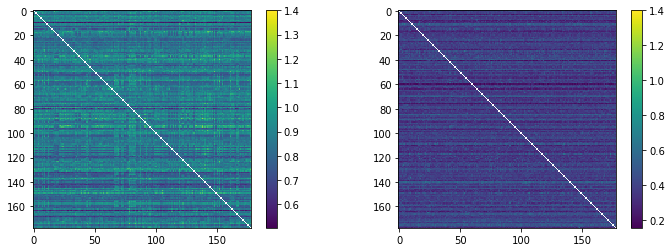

In [9]:
fig, ax = plt.subplots(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.imshow(1/real_fixed[0], vmax = 1.4)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(1/nojit_fixed[0][0], vmax = 1.4)
plt.colorbar()

In [38]:
def plot_hist_2dist(perm_data, patt_data, n_bins = 50, maxrange = 50, **kwargs):
    fig, ax = plt.subplots(figsize = (20, 6))

    col = 'tab:red'
    
    for pdat, col in zip(perm_data, ['tab:red', 'tab:orange']):
        ax.hist(pdat.flatten(), n_bins, (0, maxrange), color = col, **kwargs)
        
    ax.legend(['Voxel Reassignment', 'Innovation Jittering'], fontsize = 20)
        
    ax.set_ylabel('Random Distribution', color = col, fontsize = 26)
    ax.tick_params(axis = 'y', labelcolor = col)#, labelsize = 18)
    ax.tick_params(labelsize = 20)

    ax2 = ax.twinx()
    col = 'tab:blue'

    ax2.hist(patt_data.flatten(), n_bins, (0, maxrange), color = col, **kwargs)
    ax2.set_ylabel('Patterned Distribution', color = col, fontsize = 26)
    ax2.tick_params(axis = 'y', labelcolor = col, labelsize = 20)
    
    ax2.legend(['Real Measurement'], fontsize = 20, loc = 'upper left')
    
    ax.set_xlabel('Delay Standard Deviation', fontsize = 26)

    plt.grid()
    
    return ax, ax2

In [39]:
def interactive_hist(subj, nojit_data, jit_data, patt_data):
    ax1, ax2 = plot_hist_2dist([nojit_data[subj], jit_data[subj]],
                               patt_data[subj],
                               n_bins = 100, maxrange = 6, alpha = 0.5)
    
    ax1.set_title(run_infos.loc[subj].subj_run, fontsize = 18)
    #ax1.set_title(title + 'Subject-Run = {:02d}, stimsite is {}'
    #              .format(subj, stimsite_in_mask[subj]), fontsize = 18)
    
    #ax1, ax2 = plot_hist_2dist(jit_data[subj][thresh],
    #                           patt_data[subj][thresh],
    #                           n_bins = 100, maxrange = 20, alpha = 0.5)
    #ax1.set_title(title + 'Pre-Threshold = {:1.2f}, {}'
    #              .format(pre_thresh[thresh], parcels.subj_run[subj]), fontsize = 18)
    
    #plt.savefig('Pictures/Res_Distribution_{:02d}'.format(step))

In [40]:
interact(interactive_hist,
         subj = widgets.IntSlider(min=0, max=n_subjrun - 1, step=1, value = 0),
         nojit_data = fixed(nojit_fixed), jit_data = fixed(jit_fixed), patt_data = fixed(real_fixed))

interactive(children=(IntSlider(value=0, description='subj', max=43), Output()), _dom_classes=('widget-interac…

<function __main__.interactive_hist(subj, nojit_data, jit_data, patt_data)>

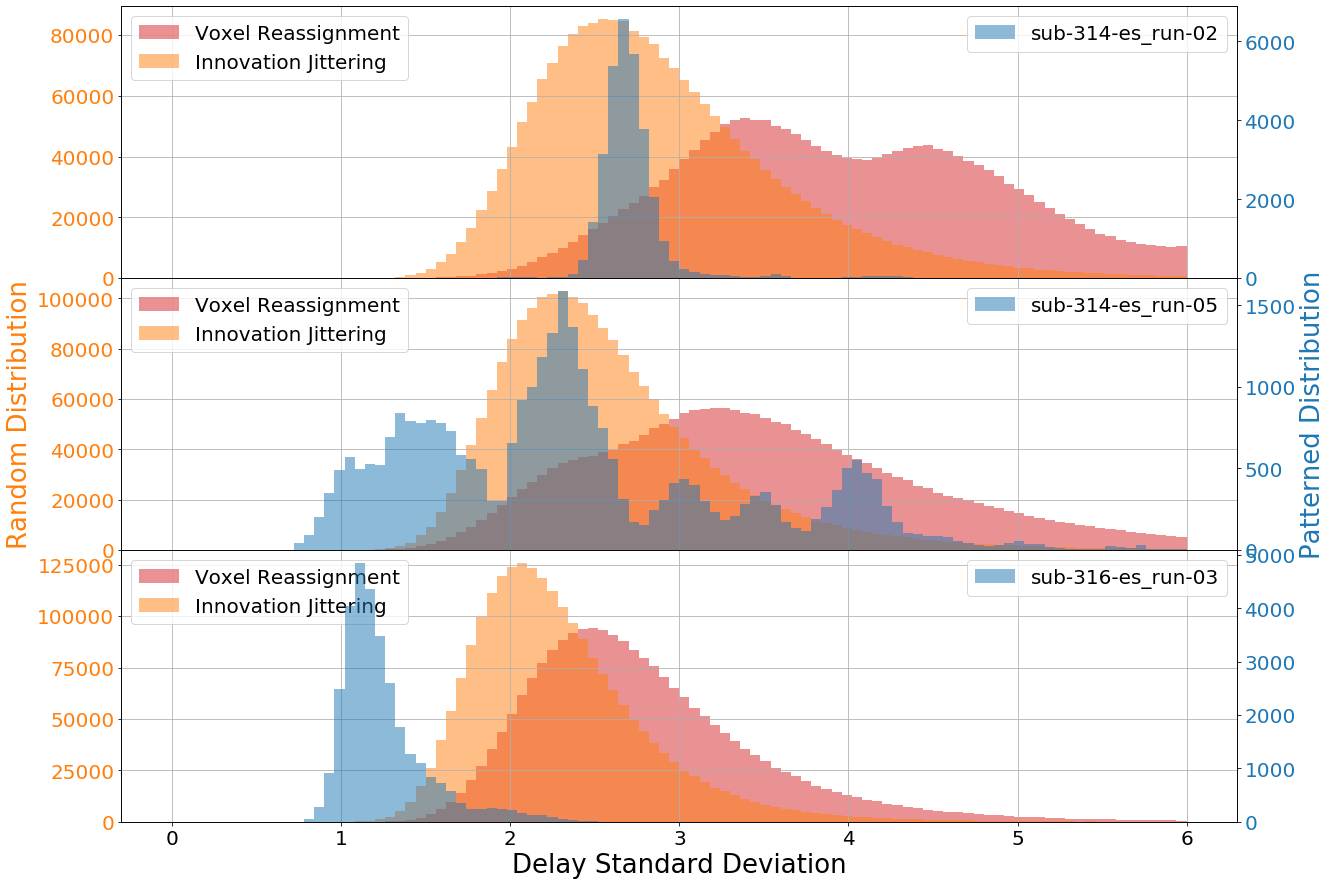

In [55]:
fig, axs = plt.subplots(figsize = (20, 15), nrows=3, sharex=True)

fig.subplots_adjust(hspace = 0)

for my_id, (my_sub, ax) in enumerate(zip([9, 12, 13], axs)):
    ax = plt.subplot(3, 1, 1 + my_id)
    
    col = 'tab:red'
    
    for pdat, col in zip([nojit_fixed[my_sub], jit_fixed[my_sub]], ['tab:red', 'tab:orange']):
        histval = ax.hist(pdat.flatten(), 100, (0, 6), color = col, alpha = 0.5)
        
    ax.legend(['Voxel Reassignment', 'Innovation Jittering'], fontsize = 20, loc = 'upper left')
    
    if my_id == 1:
        ax.set_ylabel('Random Distribution', color = col, fontsize = 26)
    ax.tick_params(axis = 'y', labelcolor = col)#, labelsize = 18)
    ax.tick_params(labelsize = 20)
    
    ax2 = ax.twinx()
    col = 'tab:blue'
    
    ax2.hist(real_fixed[my_sub].flatten(), 100, (0, 6), color = col, alpha = 0.5)
    if my_id == 1:
        ax2.set_ylabel('Patterned Distribution', color = col, fontsize = 26)
    ax2.tick_params(axis = 'y', labelcolor = col, labelsize = 20)
    
    ax2.legend([run_infos.loc[my_sub].subj_run], fontsize = 20, loc = 'upper right')
    
    if my_id == 2:
        ax.set_xlabel('Delay Standard Deviation', fontsize = 26)
        
    ax.grid()
    
plt.savefig('The_Draft/Three_hist')

No handles with labels found to put in legend.


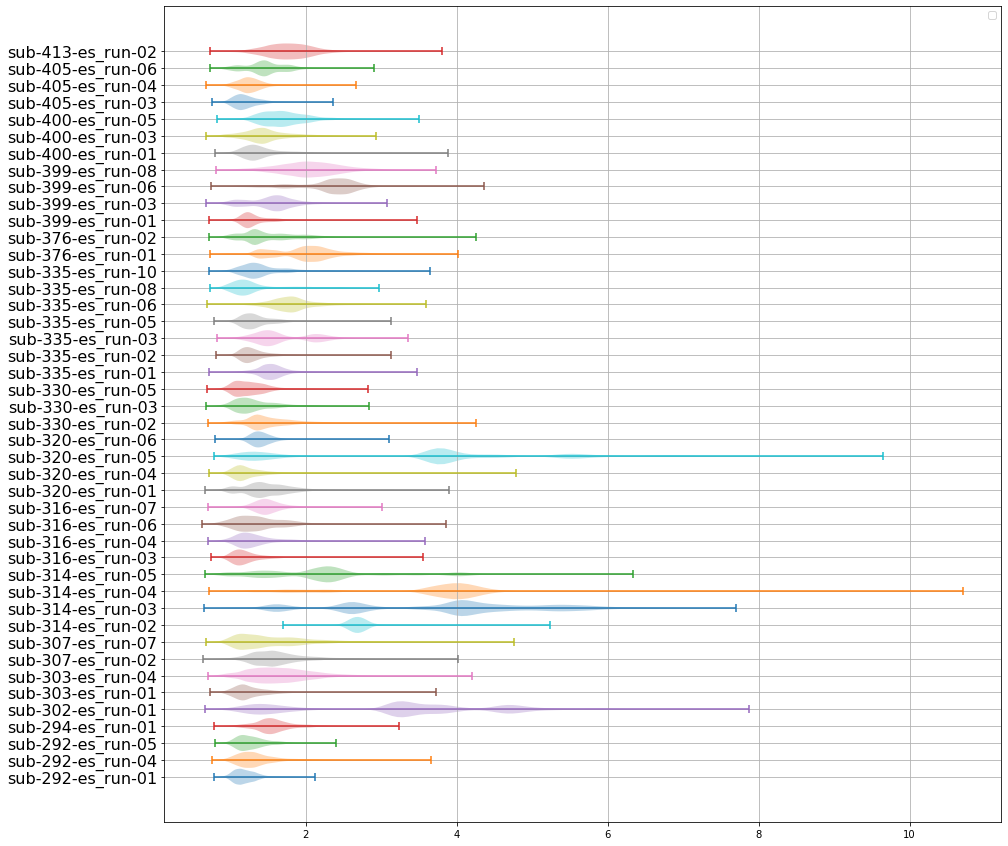

In [12]:
fig, ax = plt.subplots(figsize = (15, 15))

for sub_i, sub_dat in enumerate(real_dc):
    plt.violinplot(sub_dat[~np.isnan(sub_dat)], positions = [2*sub_i], widths = 1.9, vert = False)
    #plt.boxplot(sub_dat[~np.isnan(sub_dat)], positions = [sub_i + 1], widths = 0.8, showfliers = False)
    #plt.hist(sub_dat.flatten(), bins = 80, alpha = 0.4, range = (0, 5), label = 'Subject No{:02d}'.format(sub_i))
    
    
plt.yticks(2*np.arange(len(real_dc)), labels = run_infos.subj_run.tolist(), fontsize = 16)

#plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45, ha = "right",  rotation_mode = "anchor")
    
#plt.axis([-1, 45, -0.5, 11.5])
plt.grid()
plt.legend(ncol = 3)

# Measure on seeds

In [81]:
overlaps_parc = run_infos.overlapping_parcel_index[stimsite_in_mask].tolist()

seed_ids = [np.where(parmask == seed)[0][0] for seed in overlaps_parc]
non_seed_ids = []

for par in np.arange(221):
    if par not in seed_ids:
        non_seed_ids.append(par)

print(seed_ids)
print(overlaps_parc)

print(len(np.unique(seed_ids))+len(non_seed_ids))

run_infos.loc[stimsite_in_mask, 'seed_idx'] = seed_ids

run_infos.head()

[172, 19, 172, 140, 51, 19, 166, 40, 172, 172, 76, 141, 172, 93, 166, 46, 163, 172, 143, 172, 172, 19, 166, 172, 177, 76, 143]
[519.0, 38.0, 519.0, 372.0, 155.0, 38.0, 509.0, 108.0, 519.0, 519.0, 202.0, 374.0, 519.0, 225.0, 509.0, 143.0, 506.0, 519.0, 381.0, 519.0, 519.0, 38.0, 509.0, 519.0, 606.0, 202.0, 381.0]
221


,subject,run,overlapping_parcel_index,subj_run,all_parcels,stim_in_mask,seed_idx
0,292,1,198.0,sub-292-es_run-01,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",False,NaN
1,292,4,34.0,sub-292-es_run-04,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",False,NaN
2,292,5,32.0,sub-292-es_run-05,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",False,NaN
3,294,1,519.0,sub-294-es_run-01,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",True,172.0
4,302,1,38.0,sub-302-es_run-01,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",True,19.0


In [149]:
def inter_seed(subj, data):
    fig, ax = plt.subplots(figsize = (20, 8))
    
    to_plot = data[subj]
    
    #plt.scatter(np.arange(221), to_plot[seed_ids[subj]], marker = 'o', s = 60, alpha = 0.2, color = 'tab:blue')
    
    s_meas = to_plot[seed_ids[subj]]

    plt.plot(s_meas, linewidth = 2)
    
    non_seed = [elem != seed_ids[subj] for elem in np.arange(len(parmask))]
    
    r_meas = to_plot[non_seed]
    
    plt.plot(np.nanmean(to_plot[non_seed], axis = 0), linewidth = 2)
    
    plt.grid()
    
    r_meas = r_meas[:, ~np.isnan(s_meas)]
    s_meas = s_meas[~np.isnan(s_meas)]
    
    tval, pval = stats.ttest_1samp(r_meas, s_meas, axis = 0, nan_policy = 'omit')
    
    corr_p = len(s_meas)*pval/2
    
    is_sig_smaller = (corr_p < 0.05) & (tval > 0)
    
    plt.title('Subject {:02d} – Seed is more consistent than rest in {} of cases'
              .format(subj, sum(is_sig_smaller)), fontsize = 20)
    
interact(inter_seed, subj = widgets.IntSlider(min=0, max=sum(stimsite_in_mask) - 1, step=1, value = 0),
         data = fixed(real_fixed[stimsite_in_mask]))

interactive(children=(IntSlider(value=0, description='subj', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.inter_seed(subj, data)>

In [15]:
def conf_int(sd, n_obs=20, tstat = 2.756):
    # Two sided 95%: tstat = 1.96, 99%: tstat = 2.756
    return tstat*sd/np.sqrt(n_obs)

def bootstrap_ci(data, perc = 5, n_trials = 100):
    
    bootstraped = np.nanmean(np.random.choice(data, (len(data), n_trials), replace = True), axis = 0)
    
    lower = np.percentile(bootstraped, perc/2, interpolation = 'nearest')
    upper = np.percentile(bootstraped, 100 - perc/2, interpolation = 'nearest')
    
    return lower, upper

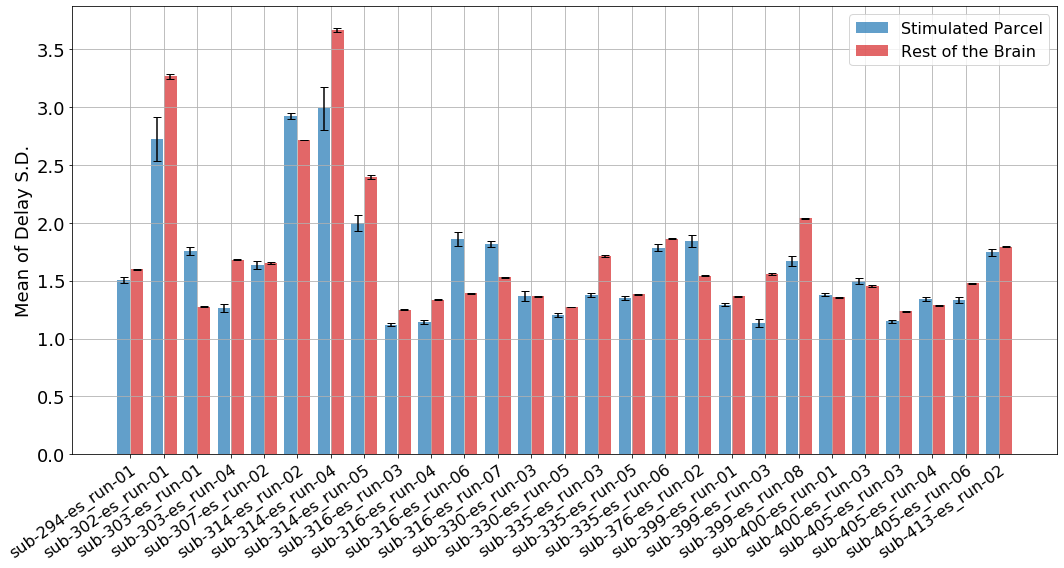

In [443]:
fig, ax = plt.subplots(figsize = (15, 8))

for sub_id, (r_data, s_id) in enumerate(zip(real_fixed[stimsite_in_mask], seed_ids)):
    
    seed_meas = r_data[s_id]
    
    #ci = np.array([bootstrap_ci(seed_meas, n_trials = 100)]).T
    #rel_ci = np.abs(ci - np.nanmean(seed_meas))
    
    rel_ci = conf_int(np.nanstd(seed_meas), len(seed_meas))
    
    plt.bar(sub_id - 0.2, np.nanmean(seed_meas), yerr = rel_ci,
            width = 0.38, color = 'tab:blue', alpha = 0.7, capsize = 4)
    
    rest_meas = r_data[[elem != s_id for elem in range(len(parmask))]].flatten()
    
    #ci = np.array([bootstrap_ci(rest_meas, n_trials = 100)]).T
    #rel_ci = np.abs(ci - np.nanmean(rest_meas))
    
    rel_ci = conf_int(np.nanstd(rest_meas), len(rest_meas))
    
    plt.bar(sub_id + 0.2, np.nanmean(rest_meas), yerr = rel_ci,
            width = 0.38, color = 'tab:red', alpha = 0.7, capsize = 4)

plt.xticks(np.arange(sum(stimsite_in_mask)), labels = run_infos[stimsite_in_mask].subj_run.tolist(), fontsize = 16)

plt.ylabel('Mean of Delay S.D.', fontsize = 18)
plt.yticks(fontsize = 18)

plt.legend(['Stimulated Parcel', 'Rest of the Brain'], fontsize = 16)


plt.setp( ax.xaxis.get_majorticklabels(), rotaddtion = 35, ha="right",  rotation_mode="anchor")

plt.grid()
#plt.tick_params(rotation = 30)

plt.tight_layout()

plt.savefig('The_Draft/Res_stim_rest_subj')

In [95]:
run_infos.overlapping_parcel_index.value_counts()

519.0    9
38.0     3
509.0    3
234.0    3
381.0    2
202.0    2
606.0    1
374.0    1
34.0     1
32.0     1
372.0    1
155.0    1
125.0    1
104.0    1
108.0    1
378.0    1
2.0      1
231.0    1
121.0    1
366.0    1
225.0    1
236.0    1
233.0    1
143.0    1
506.0    1
370.0    1
117.0    1
198.0    1
Name: overlapping_parcel_index, dtype: int64

In [115]:
run_infos.loc[:2].head()

u_stimsite = run_infos.overlapping_parcel_index.unique()

colors = plt.cm.hsv(np.linspace(0, 1, 6))

more_than_unos = np.array([519, 38, 509, 234, 381, 202])

run_infos.loc[:2].head()

#p_infos[p_infos.parcel_id in u_stimsite].name.item()

losnames = p_infos.set_index('parcel_id')
#losnames['color'] = colors[1:-1]

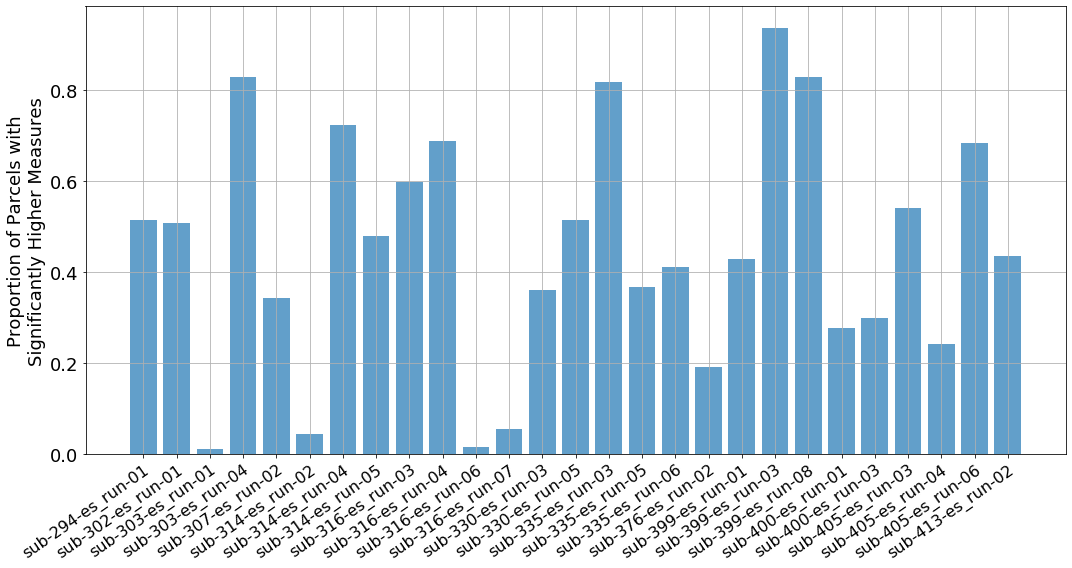

In [117]:
fig, ax = plt.subplots(figsize = (15, 8))

sig_small = np.empty(sum(stimsite_in_mask))

for sub_id, (r_data, s_id) in enumerate(zip(real_fixed[stimsite_in_mask], seed_ids)):
    
    los_parcellos = run_infos.loc[sub_id].overlapping_parcel_index.item()
    
    #if los_parcellos in more_than_unos:
    #    col = colors[np.where(more_than_unos == los_parcellos)[0]]
    #else:
    #    col = 'tab:blue'
    
    col = 'tab:blue'    
    
    seed_meas = r_data[s_id]
    
    rest_meas = r_data[[elem != s_id for elem in range(len(parmask))]]
    
    tval, pval = stats.ttest_rel(rest_meas, seed_meas + np.zeros_like(rest_meas), axis = 1, nan_policy = 'omit')
    
    corr_p = len(rest_meas)*pval/2
    is_sig_smaller = (corr_p < 0.05) & (tval > 0)
    
    sig_small[sub_id] = sum(is_sig_smaller)/len(rest_meas)
    
    plt.bar(sub_id, sig_small[sub_id], width = 0.8,# color = 'tab:blue',
            alpha = 0.7, color = col)
        
plt.xticks(np.arange(sum(stimsite_in_mask)), labels = run_infos[stimsite_in_mask].subj_run.tolist(), fontsize = 16)

plt.ylabel('Proportion of Parcels with\nSignificantly Higher Measures', fontsize = 18)
plt.yticks(fontsize = 18)

#plt.legend(['Stimulated Parcel', 'Rest of the Brain'], fontsize = 16)


plt.setp( ax.xaxis.get_majorticklabels(), rotation = 35, ha="right",  rotation_mode="anchor")

plt.grid()
#plt.tick_params(rotation = 30)

plt.tight_layout()

plt.savefig('The_Draft/Res_sig_prop_subj')

/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


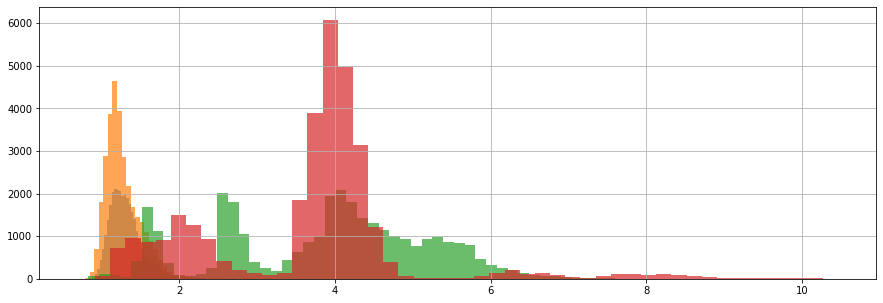

In [110]:
fig, ax = plt.subplots(figsize = (15, 5))

mymask =[2, 5, 10, 11]

for masked_id in mymask:
    plt.hist(real_fixed[masked_id].flatten(), bins = 50, alpha = 0.7, )
    
plt.grid()

# Consistency in Segregated Results

In [122]:
n_similar = sum(stimsite_in_mask)

bin_sim_nojit = np.empty((n_similar, len(parmask), len(parmask)))

percentile = 1

i_sim = 0

for sub_id in range(n_subjrun):
    if stimsite_in_mask[sub_id]:
        bin_sim_nojit[i_sim] = fmri_delay.empirical_null_dist(real_fixed[sub_id], nojit_fixed[sub_id],
                                                            alpha_level = percentile)
        
        i_sim += 1

/Users/AlexCionca/miniconda3/PROJ/_PDM/fmri_delay/fmri_delay/validation.py:123: RuntimeWarning: invalid value encountered in less
  bin_results = (real_meas < empirical_bound).astype(int)


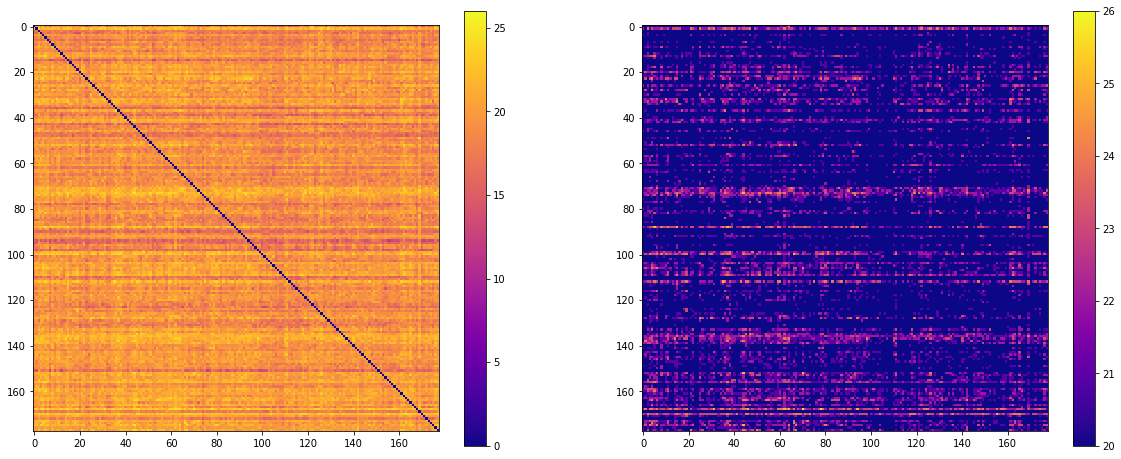

In [123]:
fig, ax = plt.subplots(figsize = (20, 8))

plt.subplot(1, 2, 1)
plt.imshow(bin_sim_nojit.sum(axis = 0), cmap = 'plasma')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(bin_sim_nojit.sum(axis = 0), vmin = 20, cmap = 'plasma')
plt.colorbar()

/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.]),
 <a list of 11 Text xticklabel objects>)

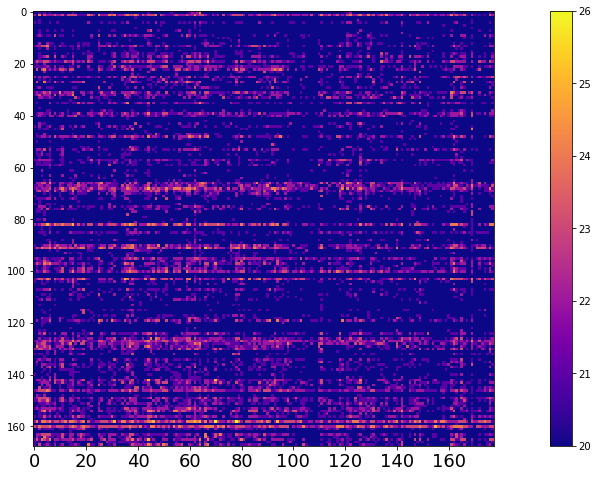

In [124]:
fig, ax = plt.subplots(figsize = (20, 8))

above20 = np.where(bin_sim_nojit.sum(axis = 0) > 20)

u_activ = np.unique(above20[0])
u_fol = np.unique(above20[1])

act_name = p_infos.set_index('parcel_id').loc[parmask[u_activ]].name.tolist()
fol_name = p_infos.set_index('parcel_id').loc[parmask[u_fol]].name.tolist()

highlight = [[i for i in u_activ for j in u_fol],
             [j for i in u_activ for j in u_fol]]

plt.imshow(bin_sim_nojit.sum(axis = 0)[highlight].reshape((len(u_activ), -1)), vmin = 20, cmap = 'plasma')
plt.colorbar()

#plt.yticks(-0.5 + np.arange(len(u_activ)+1), labels = ['']+act_name, minor = True)
plt.xticks(fontsize = 18)

#plt.setp( ax.xaxis.get_majorticklabels(), rotation=30, ha="right",  rotation_mode="anchor")

In [125]:
n_similar = sum(stimsite_in_mask)

bin_sim_jit = np.empty((n_similar, len(parmask), len(parmask)))

percentile = 1

i_sim = 0

for sub_id in range(n_subjrun):
    if stimsite_in_mask[sub_id]:
        bin_sim_jit[i_sim] = fmri_delay.empirical_null_dist(real_fixed[sub_id], jit_fixed[sub_id],
                                                            alpha_level = percentile)
        
        i_sim += 1

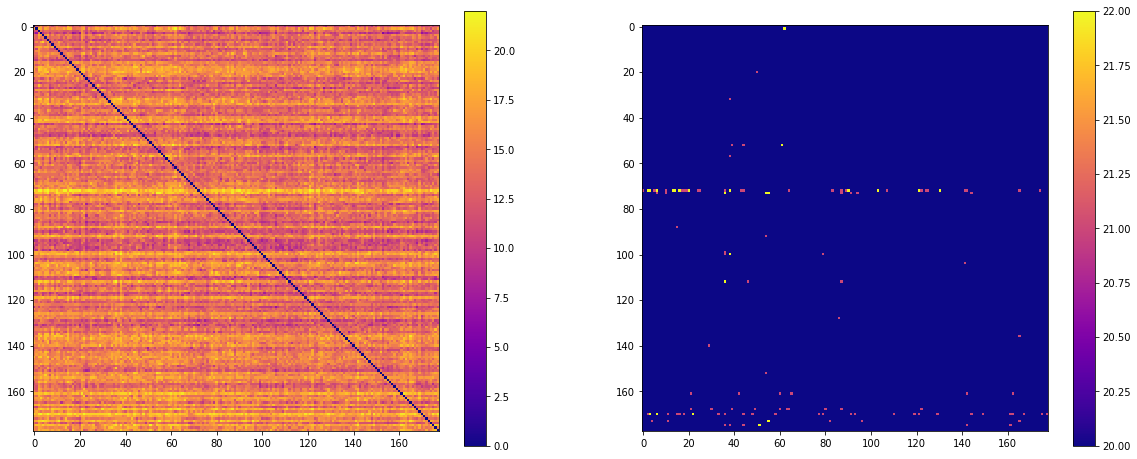

In [126]:
fig, ax = plt.subplots(figsize = (20, 8))

plt.subplot(1, 2, 1)
plt.imshow(bin_sim_jit.sum(axis = 0), cmap = 'plasma')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(bin_sim_jit.sum(axis = 0), vmin = 20, cmap = 'plasma')
plt.colorbar()

/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 <a list of 10 Text xticklabel objects>)

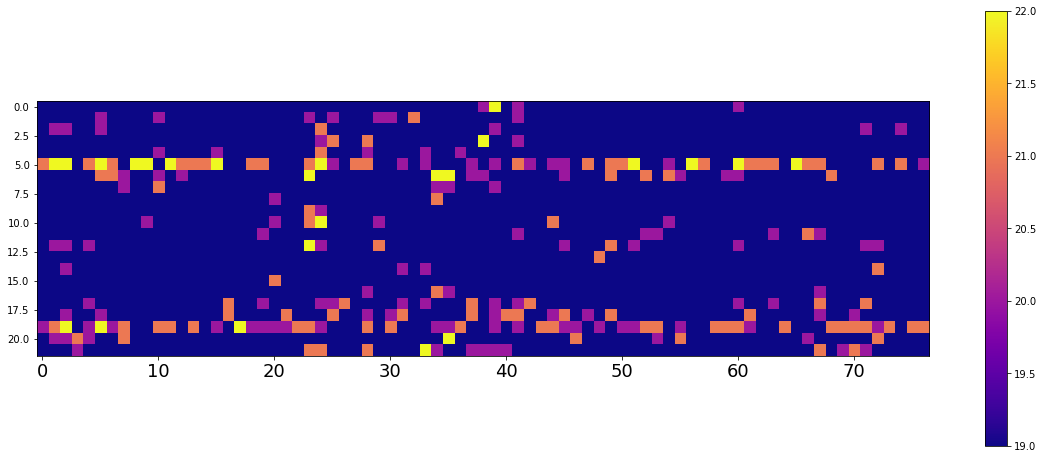

In [127]:
fig, ax = plt.subplots(figsize = (20, 8))

above20 = np.where(bin_sim_jit.sum(axis = 0) > 20)

u_activ = np.unique(above20[0])
u_fol = np.unique(above20[1])

act_name = p_infos.set_index('parcel_id').loc[parmask[u_activ]].name.tolist()
fol_name = p_infos.set_index('parcel_id').loc[parmask[u_fol]].name.tolist()

highlight = [[i for i in u_activ for j in u_fol],
             [j for i in u_activ for j in u_fol]]

plt.imshow(bin_sim_jit.sum(axis = 0)[highlight].reshape((len(u_activ), -1)), vmin = 19, cmap = 'plasma')
plt.colorbar()

#plt.yticks(-0.5 + np.arange(len(u_activ)+1), labels = ['']+act_name, minor = True)
plt.xticks(fontsize = 18)

#plt.setp( ax.xaxis.get_majorticklabels(), rotation=30, ha="right",  rotation_mode="anchor")

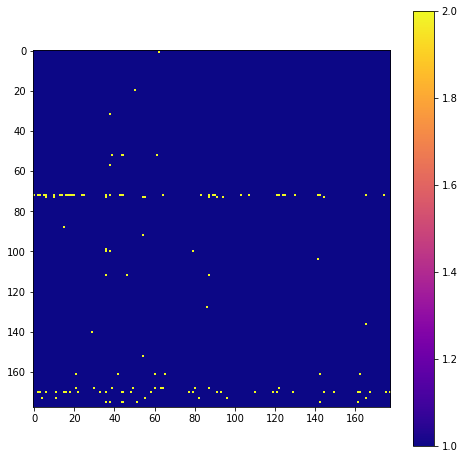

In [128]:
cons_bin = (bin_sim_nojit.sum(axis = 0) > 20).astype(int) + (bin_sim_jit.sum(axis = 0) > 20).astype(int)

fig, ax = plt.subplots(figsize = (8, 8))

plt.imshow(cons_bin, cmap = 'plasma', vmin = 1)
plt.colorbar()

## Similarity with Jaccard

In [129]:
def Jaccard(bin_one, bin_two):
    summed = (bin_one + bin_two)
    
    similar = np.sum(summed > 1)
    total = np.sum(summed > 0)
    
    return similar/total

In [130]:
sub_in_mask = np.where(stimsite_in_mask)[0]

jaccard_nojit = np.ones((sum(stimsite_in_mask), sum(stimsite_in_mask)))
jaccard_jit = np.ones((sum(stimsite_in_mask), sum(stimsite_in_mask)))

jaccard_inter_method = np.empty(sum(stimsite_in_mask))


for i in range(sum(stimsite_in_mask)):
    for j in range(i + 1, sum(stimsite_in_mask), 1):
        
        jaccard_nojit[i, j] = Jaccard(bin_sim_nojit[i], bin_sim_nojit[j])
        jaccard_nojit[j, i] = jaccard_nojit[i, j]
        
        jaccard_jit[i, j] = Jaccard(bin_sim_jit[i], bin_sim_jit[j])
        jaccard_jit[j, i] = jaccard_jit[i, j]
        
    jaccard_inter_method[i] = Jaccard(bin_sim_jit[i], bin_sim_nojit[i])

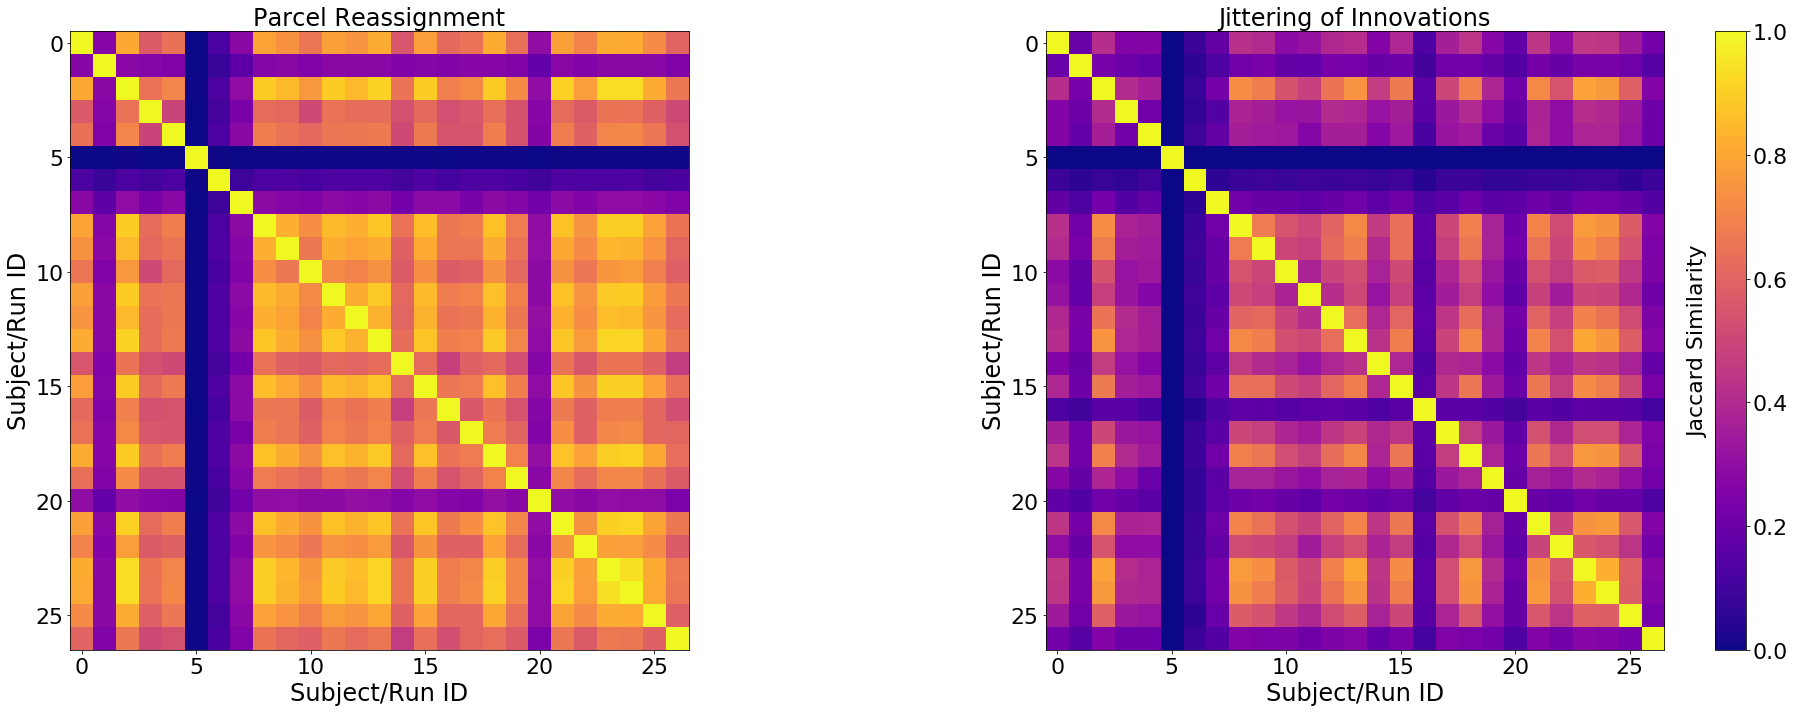

In [144]:
fig, ax = plt.subplots(figsize = (28, 10))

ax1 = plt.subplot(1, 2, 1)
plt.title('Parcel Reassignment', fontsize = 24)

plt.imshow(jaccard_nojit, cmap = 'plasma')

plt.xlabel('Subject/Run ID', fontsize = 24)
plt.ylabel('Subject/Run ID', fontsize = 24)
plt.tick_params(labelsize = 22)

#plt.colorbar()

ax2 = plt.subplot(1, 2, 2)
plt.title('Jittering of Innovations', fontsize = 24)

plt.imshow(jaccard_jit, cmap = 'plasma')

plt.xlabel('Subject/Run ID', fontsize = 24)
plt.ylabel('Subject/Run ID', fontsize = 24)
plt.tick_params(labelsize = 22)

cbar = plt.colorbar()
cbar.ax.set_ylabel('Jaccard Similarity', fontsize = 22, labelpad = -100)
cbar.ax.tick_params(labelsize = 22)

plt.tight_layout()

plt.savefig('The_Draft/Res_Jaccard_subj')

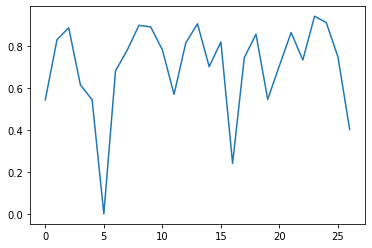

In [380]:
plt.plot(jaccard_inter_method)

In [268]:
overlaps_parc = run_infos.overlapping_parcel_index[stimsite_in_mask].tolist()

seed_ids = [np.where(parmask == seed)[0][0] for seed in overlaps_parc]

print(seed_ids)

[172, 19, 172, 140, 51, 19, 166, 40, 172, 172, 76, 141, 172, 93, 166, 46, 163, 172, 143, 172, 172, 19, 166, 172, 177, 76, 143]


IndexError: index 178 is out of bounds for axis 0 with size 178

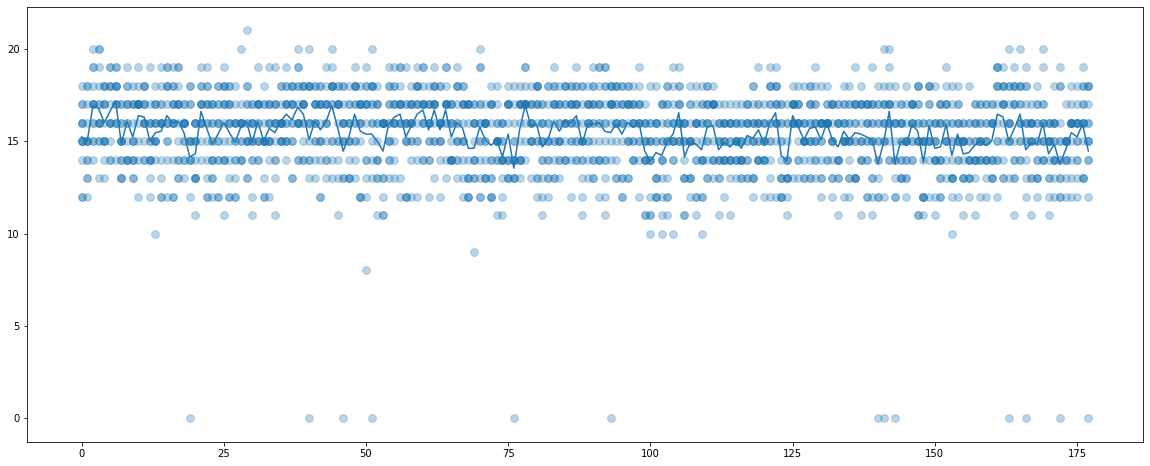

In [26]:
fig, ax = plt.subplots(figsize = (20, 8))


plt.plot(bin_similar.sum(axis = 0)[np.unique(seed_ids)].mean(axis = 0))

for fdp in bin_similar.sum(axis = 0)[np.unique(seed_ids)]:
    plt.scatter(np.arange(len(parmask)), fdp, marker = 'o', s = 60, alpha = 0.3, color = 'tab:blue')
    
    
plt.plot(bin_similar.sum(axis = 0)[non_seed_ids].mean(axis = 0))
    
plt.grid()
#plt.imshow(bin_similar.sum(axis = 0))

# Consistency as fct of Stim-Site
## Both from the seed and whole brain

In [326]:
run_infos.head(2)

,subject,run,overlapping_parcel_index,subj_run,all_parcels,stim_in_mask,seed_idx
0,292,1,198.0,sub-292-es_run-01,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",False,NaN
1,292,4,34.0,sub-292-es_run-04,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",False,NaN


In [329]:
mytest = run_infos.copy()

mytest['n_reg'] = mytest.all_parcels.apply(len)

mytest

,subject,run,overlapping_parcel_index,subj_run,all_parcels,stim_in_mask,seed_idx,n_reg
0,292,1,198.0,sub-292-es_run-01,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",False,NaN,348
1,292,4,34.0,sub-292-es_run-04,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",False,NaN,348
2,292,5,32.0,sub-292-es_run-05,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",False,NaN,348
3,294,1,519.0,sub-294-es_run-01,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",True,172.0,356
4,302,1,38.0,sub-302-es_run-01,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",True,19.0,393
5,303,1,519.0,sub-303-es_run-01,"[3, 4, 5, 6, 8, 9, 10, 11, 13, 15, 16, 18, 19,...",True,172.0,359
6,303,4,372.0,sub-303-es_run-04,"[3, 4, 5, 6, 8, 9, 10, 11, 13, 15, 16, 18, 19,...",True,140.0,359
7,307,2,155.0,sub-307-es_run-02,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",True,51.0,389
8,307,7,125.0,sub-307-es_run-07,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",False,NaN,389
9,314,2,38.0,sub-314-es_run-02,"[8, 10, 11, 15, 16, 18, 19, 20, 21, 22, 24, 25...",True,19.0,375


In [330]:
real_dc[3].shape

(356, 356)

348 parcels are consistent throughout 1 subjects/runs
348 parcels are consistent throughout 1 subjects/runs
348 parcels are consistent throughout 1 subjects/runs
232 parcels are consistent throughout 9 subjects/runs
105
5
144
167
75
40
219
194
121
319 parcels are consistent throughout 3 subjects/runs
158
18
101


/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `item` has been deprecated and will be removed in a future version


359 parcels are consistent throughout 1 subjects/runs
389 parcels are consistent throughout 1 subjects/runs
389 parcels are consistent throughout 1 subjects/runs
375 parcels are consistent throughout 1 subjects/runs
305 parcels are consistent throughout 3 subjects/runs
224
252
97
375 parcels are consistent throughout 1 subjects/runs
350 parcels are consistent throughout 2 subjects/runs
15
247
393 parcels are consistent throughout 1 subjects/runs
390 parcels are consistent throughout 1 subjects/runs
336 parcels are consistent throughout 3 subjects/runs
24
307
108
390 parcels are consistent throughout 1 subjects/runs
390 parcels are consistent throughout 1 subjects/runs
398 parcels are consistent throughout 1 subjects/runs
398 parcels are consistent throughout 1 subjects/runs
365 parcels are consistent throughout 1 subjects/runs
365 parcels are consistent throughout 1 subjects/runs
365 parcels are consistent throughout 1 subjects/runs
365 parcels are consistent throughout 1 subjects/runs

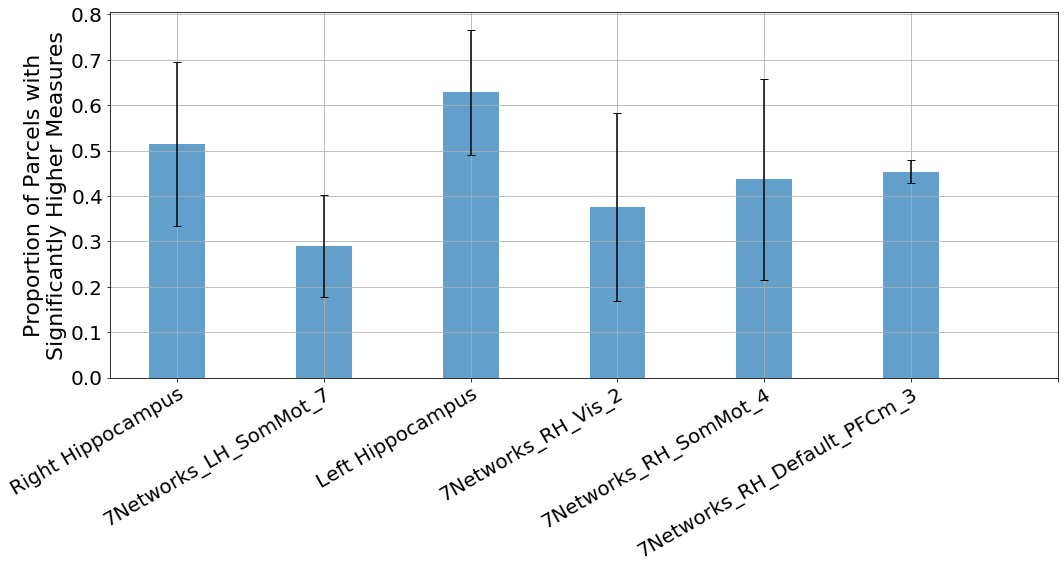

In [475]:
fig, ax = plt.subplots(figsize = (15, 8))

fig.subplots_adjust(wspace = 0)

bs_ci = False

parcel_names = []

n_useeds = len(run_infos.overlapping_parcel_index.unique())

k = 0


sig_consistency = np.empty(n_useeds)

for u_s_id, u_seed in enumerate(run_infos.overlapping_parcel_index.unique()):
    subset = (run_infos.overlapping_parcel_index == u_seed).tolist()
    
    
    real_subset, subset_parmask = fix_parcellation(real_dc, rand_nojit, rand_jit, subset_ids = subset,
                                                   do_rand = False)
    
    if len(real_subset) > 1:
        parcel_names.append(p_infos[p_infos.parcel_id == u_seed].name.item())
    
        s_id = np.where(subset_parmask == u_seed)[0][0]
        
        sig_small = []
        
        for ind_id, indiv_real in enumerate(real_subset):
            #if ind_id != 1 or u_s_id != 3:
            rest_mask = [True]*len(subset_parmask)
            rest_mask[s_id] = False

            seed_meas = indiv_real[s_id]#.flatten()
            rest_meas = indiv_real[rest_mask]#.flatten()

            tval, pval = stats.ttest_rel(rest_meas, seed_meas + np.zeros_like(rest_meas),
                                         axis = 1, nan_policy = 'omit')

            corr_p = len(rest_meas)*pval/2
            is_sig_smaller = (corr_p < 0.05) & (tval > 0)


            print(sum(is_sig_smaller))
            sig_small.append(sum(is_sig_smaller))
            
        ci = conf_int(np.std(np.array(sig_small)/(sum(subset)*len(pval))), 2.576, sum(subset))
        
        plt.bar(k, np.sum(sig_small)/(sum(subset)*len(pval)), yerr = ci,
                width = 0.38, color = 'tab:blue', alpha = 0.7, capsize = 4)
        
        k += 1
    

plt.xticks(np.arange(k + 1), labels = parcel_names, fontsize = 18)
plt.ylabel('Proportion of Parcels with\nSignificantly Higher Measures', fontsize = 22)

ax.tick_params(labelsize = 20)

plt.setp( ax.xaxis.get_majorticklabels(), rotation=30, ha="right",  rotation_mode="anchor")

ax.grid()
plt.tight_layout()

plt.savefig('The_Draft/Res_sig_prop_stim')

/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `item` has been deprecated and will be removed in a future version
  from ipykernel import kernelapp as app


348 parcels are consistent throughout 1 subjects/runs
326
348 parcels are consistent throughout 1 subjects/runs
13
348 parcels are consistent throughout 1 subjects/runs
132
232 parcels are consistent throughout 9 subjects/runs
108
7
147
173
78
45
220
199
125
319 parcels are consistent throughout 3 subjects/runs
159
19
106
359 parcels are consistent throughout 1 subjects/runs
308
389 parcels are consistent throughout 1 subjects/runs
137
389 parcels are consistent throughout 1 subjects/runs
131
375 parcels are consistent throughout 1 subjects/runs
243
305 parcels are consistent throughout 3 subjects/runs
224
259
102
375 parcels are consistent throughout 1 subjects/runs
181
350 parcels are consistent throughout 2 subjects/runs
21
249
393 parcels are consistent throughout 1 subjects/runs
27
390 parcels are consistent throughout 1 subjects/runs
278
336 parcels are consistent throughout 3 subjects/runs
24
308
114
390 parcels are consistent throughout 1 subjects/runs
380
390 parcels are consi

KeyboardInterrupt: 

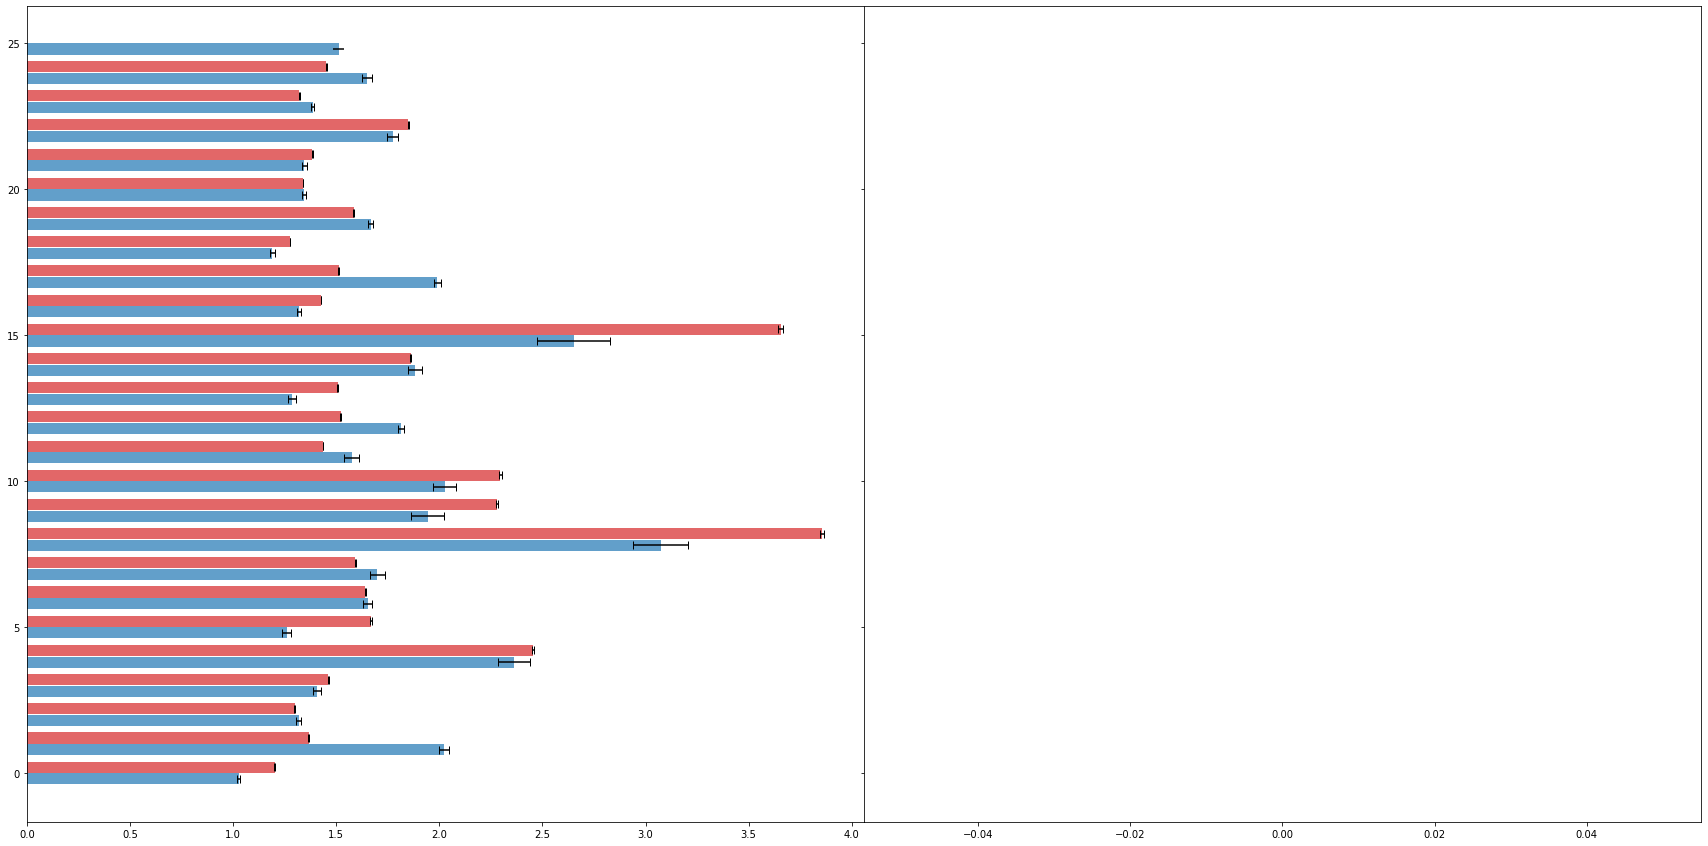

In [455]:
fig, (ax1, ax2) = plt.subplots(figsize = (30, 15), ncols = 2, sharey = True)

fig.subplots_adjust(wspace = 0)

bs_ci = False

parcel_names = []

n_useeds = len(run_infos.overlapping_parcel_index.unique())

for u_s_id, u_seed in enumerate(run_infos.overlapping_parcel_index.unique()):
    subset = (run_infos.overlapping_parcel_index == u_seed).tolist()

    
    parcel_names.append(p_infos[p_infos.parcel_id == u_seed].name.item())
    
    real_subset, subset_parmask = fix_parcellation(real_dc, rand_nojit, rand_jit, subset_ids = subset,
                                                   do_rand = False)
    
    s_id = np.where(subset_parmask == u_seed)[0][0]
    
    rest_mask = [True]*len(subset_parmask)
    rest_mask[s_id] = False
    
    seed_meas = real_subset[:, s_id]#.flatten()
    rest_meas = real_subset[:, rest_mask]#.flatten()
    
    sig_fol = np.zeros_like(subset_parmask)
    
    for s_meas, r_meas in zip(seed_meas, rest_meas):
        #tval, pval = stats.ttest_1samp(r_meas, s_meas, axis = 0, nan_policy = 'omit')
        tval, pval = stats.ttest_rel(r_meas, s_meas + np.zeros_like(r_meas), axis = 1, nan_policy = 'omit')
        
        corr_p = len(seed_meas)*pval/2

        is_sig_smaller = (corr_p < 0.05) & (tval > 0)
        
        print(sum(is_sig_smaller))
        
        #sig_fol += is_sig_smaller
        
    sig_consistency
    
    if bs_ci:
        ci = np.array([bootstrap_ci(seed_meas, n_trials = 100)]).T
        rel_ci = np.abs(ci - np.nanmean(seed_meas))
    else:
        rel_ci = conf_int(np.nanstd(seed_meas), len(seed_meas.flatten()))
    
    ax1.barh(u_s_id - 0.2, np.nanmean(seed_meas), xerr = rel_ci,
            height = 0.38, color = 'tab:blue', alpha = 0.7, capsize = 4)
    
    if bs_ci:
        ci = np.array([bootstrap_ci(rest_meas, n_trials = 100)]).T
        rel_ci = np.abs(ci - np.nanmean(rest_meas))
    else:
        rel_ci = conf_int(np.nanstd(rest_meas), len(rest_meas.flatten()))
    
    ax1.barh(u_s_id + 0.2, np.nanmean(rest_meas), xerr = rel_ci,
            height = 0.38, color = 'tab:red', alpha = 0.7, capsize = 4)
    
    more_than_75 = sum(sig_fol > sum(subset)*0.75)
    ax2.barh(u_s_id, more_than_75, color = 'tab:orange', alpha = 0.7)
    

plt.yticks(np.arange(u_s_id + 1), labels = parcel_names, fontsize = 18)

ax1.set_xticks(np.arange(0, 4, 0.5))

ax1.tick_params(labelsize = 20)
ax2.tick_params(labelsize = 20)

ax1.legend(['Stimulated Parcel', 'Rest of the Brain'], fontsize = 16)
ax2.legend(['# Seed Consistencies'], fontsize = 16)

#plt.setp( ax.xaxis.get_majorticklabels(), rotation=30, ha="right",  rotation_mode="anchor")

ax1.grid()
ax2.grid()

# RIGHT HIPPOCAMPUS ANALYSIS

In [231]:
r_hip_id = 519

r_hip_subset = (parcel_data.overlapping_parcel_index == r_hip_id).tolist()

real_rhip, nojit_rhip, jit_rhip, rhip_parmask = fix_parcellation(real_dc, rand_nojit, rand_jit,
                                                                 subset_ids = r_hip_subset, do_rand = True)

232 parcels are consistent throughout 9 subjects/runs


In [240]:
sig_followers = np.zeros(len(rhip_parmask))

perc = 1

bin_res_rhip = np.empty((len(real_rhip), 2, len(rhip_parmask), len(rhip_parmask)))

#for sub_measure in real_rhip:
for subj_rhip_id, (sub_measure, sub_nojit, sub_jit) in enumerate(zip(real_rhip, nojit_rhip, jit_rhip)):
    
    s_id = np.where(rhip_parmask == r_hip_id)[0][0]
    
    rest_mask = [True]*len(rhip_parmask)
    rest_mask[s_id] = False
    
    seed_meas = sub_measure[:, s_id].flatten()
    rest_meas = sub_measure[:, rest_mask].flatten()
    
    ## Binarization
    bin_res_rhip[subj_rhip_id, 0] = fmri_delay.empirical_null_dist(sub_measure, sub_nojit, alpha_level = perc)
    bin_res_rhip[subj_rhip_id, 1] = fmri_delay.empirical_null_dist(sub_measure, sub_jit, alpha_level = perc)
    
    ## Stat test of diff between seed and rest
    tval, pval = stats.ttest_1samp(rest_meas, seed_meas, axis = 0, nan_policy = 'omit')
    
    corr_p = 9*len(seed_meas)*pval/2
    
    is_sig_smaller = (corr_p < 0.005) & (tval > 0)
    sig_followers += is_sig_smaller

/Users/AlexCionca/miniconda3/PROJ/_PDM/fmri_delay/fmri_delay/validation.py:123: RuntimeWarning: invalid value encountered in less
  bin_results = (real_meas < empirical_bound).astype(int)
/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


In [254]:
p_infos.set_index('parcel_id').loc[rhip_parmask[sig_followers >= 8]]

,abbr,name
parcel_id,,
235,NaN,7Networks_RH_SomMot_5
239,NaN,7Networks_RH_SomMot_9
260,NaN,7Networks_RH_SomMot_30
313,NaN,7Networks_RH_SalVentAttn_Med_3
374,NaN,7Networks_RH_Default_Temp_8
392,NaN,7Networks_RH_Default_PCC_1
400,NaN,7Networks_RH_Default_PCC_9
606,AMY_BL_R,amygdala_basolateral_right


In [242]:
rhip_parmask[sig_followers >= 8]

array([235, 239, 260, 313, 374, 392, 400, 606])

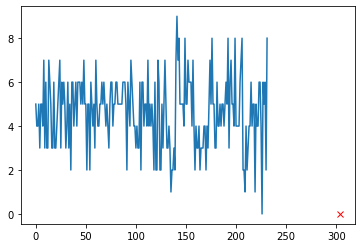

In [319]:
plt.plot(sig_followers)
plt.plot(s_id, [0], 'rx')

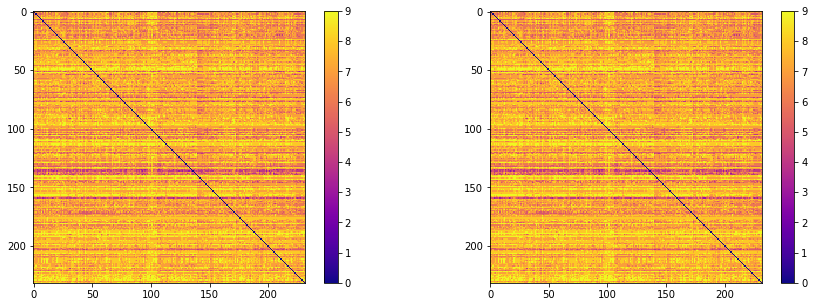

In [247]:
fig, ax = plt.subplots(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.imshow(bin_res_rhip[:, 0].sum(axis = 0), cmap = 'plasma')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(bin_res_rhip[:, 0].sum(axis = 0), cmap = 'plasma')
plt.colorbar()

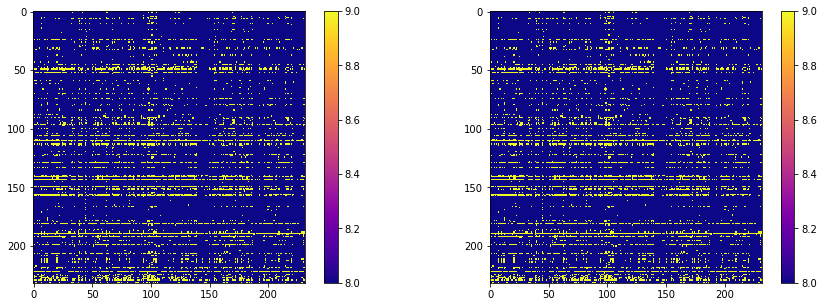

In [248]:
fig, ax = plt.subplots(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.imshow(bin_res_rhip[:, 0].sum(axis = 0), cmap = 'plasma', vmin = 8)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(bin_res_rhip[:, 0].sum(axis = 0), cmap = 'plasma', vmin = 8)
plt.colorbar()

In [481]:
len(np.where(np.isnan(real_rhip))[0])

2088

In [496]:
np.nanmin(real_rhip.reshape((9, -1)), axis = 1)

array([0.81940163, 0.78026277, 0.76262522, 0.72629195, 0.68426967,
       0.7592028 , 0.72261006, 0.81696732, 0.76083506])